# Guided Project: Answering Business Questions Using SQL

In this project as a capstone of Intermediate SQL Course, we are going to practice using SQL skills to answer hypothetical business questions.

### Setting Up
The first task was getting connected to the chinook database within the jupyter kernel

In [1]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

'Connected: None@chinook.db'

In [2]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline

### Popular Music Genre in the US

We want to decide which of the three following artists to stock in Chinook record store based on the most popular genres in the US.

#### Getting the Overview of the dataset

In [3]:
%%sql
SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table","view");

Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


I would like to view the contents of whatever I'm selling, so I decided to pull out an edited table including albums and genres with artist's names ranked by the most track sales in the US

In [4]:
%%sql
SELECT t.name track_name,
       ar.name artist_name,
       al.title album_name,
       g.name genre,
       count(*) tracks_sold
FROM invoice i
LEFT JOIN invoice_line il ON i.invoice_id = il.invoice_id
LEFT JOIN track t ON t.track_id = il.track_id
LEFT JOIN genre g ON g.genre_id = t.genre_id
LEFT JOIN album al ON al.album_id = t.album_id
LEFT JOIN artist ar ON ar.artist_id = al.artist_id
WHERE i.billing_country = 'USA'
GROUP BY track_name, artist_name, album_name, genre
ORDER BY 5 DESC
LIMIT 40

Done.


track_name,artist_name,album_name,genre,tracks_sold
War Pigs,Cake,Cake: B-Sides and Rarities,Alternative,6
You Know I'm No Good (feat. Ghostface Killah),Amy Winehouse,Back to Black,R&B/Soul,5
End Of The Night,The Doors,The Doors,Rock,4
Evil Woman,Black Sabbath,Black Sabbath,Metal,4
Highway Chile,Jimi Hendrix,Are You Experienced?,Rock,4
I Looked At You,The Doors,The Doors,Rock,4
Night Of The Long Knives,AC/DC,For Those About To Rock We Salute You,Rock,4
Scentless Apprentice,Nirvana,From The Muddy Banks Of The Wishkah [live],Rock,4
Violent Pornography,System Of A Down,Mezmerize,Metal,4
Are You Experienced?,Jimi Hendrix,Are You Experienced?,Rock,3


Next, I will calculate "Total_sold" as a subquerry so I could use it to calculate for percentage of genre sold.

In [5]:
%%sql
WITH genre_most_tsold AS
    (
    SELECT 
            g.name genre_name, 
            COUNT(il.quantity) track_solds
    FROM track t
    INNER JOIN genre g ON g.genre_id = t.genre_id
    INNER JOIN invoice_line il ON il.track_id = t.track_id
    INNER JOIN invoice i ON i.invoice_id = il.invoice_id
    INNER JOIN customer c ON c.customer_id = i.customer_id
    WHERE c.country = "USA"
    GROUP BY g.genre_id
    )
    
SELECT *, ROUND(CAST(track_solds AS FLOAT) * 100.0 / (
                                        SELECT SUM(track_solds) Total_sold 
                                        FROM genre_most_tsold
                                        ),2) AS percentage
FROM genre_most_tsold
ORDER BY track_solds DESC;

Done.


genre_name,track_solds,percentage
Rock,561,53.38
Alternative & Punk,130,12.37
Metal,124,11.8
R&B/Soul,53,5.04
Blues,36,3.43
Alternative,35,3.33
Latin,22,2.09
Pop,22,2.09
Hip Hop/Rap,20,1.9
Jazz,14,1.33


In [6]:
query = """
WITH genre_most_tsold AS
    (
    SELECT 
            g.name genre_name, 
            COUNT(il.quantity) track_solds
    FROM track t
    INNER JOIN genre g ON g.genre_id = t.genre_id
    INNER JOIN invoice_line il ON il.track_id = t.track_id
    INNER JOIN invoice i ON i.invoice_id = il.invoice_id
    INNER JOIN customer c ON c.customer_id = i.customer_id
    WHERE c.country = "USA"
    GROUP BY g.genre_id
    )
    
SELECT *, ROUND(CAST(track_solds AS FLOAT) * 100.0 / (
                                        SELECT SUM(track_solds) Total_sold 
                                        FROM genre_most_tsold
                                        ),2) AS percentage
FROM genre_most_tsold
ORDER BY track_solds DESC;
"""

#Transform SQL to pandas:
conn = sqlite3.connect("chinook.db")
df = pd.read_sql_query(query, conn) 
df = df.set_index('genre_name', drop = True) #setting genre_name as index
df

,track_solds,percentage
genre_name,,
Rock,561,53.38
Alternative & Punk,130,12.37
Metal,124,11.80
R&B/Soul,53,5.04
Blues,36,3.43
Alternative,35,3.33
Latin,22,2.09
Pop,22,2.09
Hip Hop/Rap,20,1.90


KeyError: 'percentage'

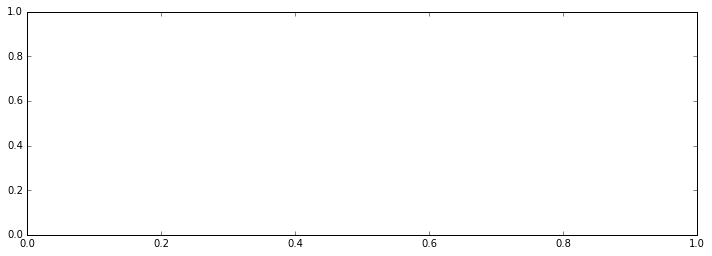

In [48]:
# Plotting sold tracks by genre in %
fig, ax = plt.subplots(figsize=(12,4))
df["percentage"].sort_values().plot.bar(color="grey",
                                  xlim=(0, 60),
                                  rot=0)
plt.setp(ax.get_xticklabels(),
         rotation=45,
         ha="right",
         rotation_mode="anchor")
ax.set_title("Sold albums and tracks by genre", fontsize=38)
ax.tick_params(axis="both", 
               labelsize=20,
               left = False)

ax.grid(color='black', axis='y')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

From the resulted table above describing the most popular genre in terms of track_solds, Rock genre is the best selling with over `50%` sold at the store. Thus, from the deal we signed, tasked with selecting genres to stock in. Punk, Blues, and Pop in popularity order should be selected to be stocked in Chinook record.

### Analyzing Employee Sales Performance

Each customers from the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. My task is to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing eiher better or worse than the others.

In [7]:
%%sql
SELECT 
        e.*, 
        i.*
FROM invoice i
LEFT JOIN customer c ON i.customer_id = c.customer_id
LEFT JOIN employee e ON c.support_rep_id = e.employee_id
LIMIT 40;

Done.


employee_id,last_name,first_name,title,reports_to,birthdate,hire_date,address,city,state,country,postal_code,phone,fax,email,invoice_id,customer_id,invoice_date,billing_address,billing_city,billing_state,billing_country,billing_postal_code,total
3,Peacock,Jane,Sales Support Agent,2,1973-08-29 00:00:00,2017-04-01 00:00:00,1111 6 Ave SW,Calgary,AB,Canada,T2P 5M5,+1 (403) 262-3443,+1 (403) 262-6712,jane@chinookcorp.com,1,18,2017-01-03 00:00:00,627 Broadway,New York,NY,USA,10012-2612,15.84
3,Peacock,Jane,Sales Support Agent,2,1973-08-29 00:00:00,2017-04-01 00:00:00,1111 6 Ave SW,Calgary,AB,Canada,T2P 5M5,+1 (403) 262-3443,+1 (403) 262-6712,jane@chinookcorp.com,2,30,2017-01-03 00:00:00,230 Elgin Street,Ottawa,ON,Canada,K2P 1L7,9.9
4,Park,Margaret,Sales Support Agent,2,1947-09-19 00:00:00,2017-05-03 00:00:00,683 10 Street SW,Calgary,AB,Canada,T2P 5G3,+1 (403) 263-4423,+1 (403) 263-4289,margaret@chinookcorp.com,3,40,2017-01-05 00:00:00,"8, Rue Hanovre",Paris,None,France,75002,1.98
3,Peacock,Jane,Sales Support Agent,2,1973-08-29 00:00:00,2017-04-01 00:00:00,1111 6 Ave SW,Calgary,AB,Canada,T2P 5M5,+1 (403) 262-3443,+1 (403) 262-6712,jane@chinookcorp.com,4,18,2017-01-06 00:00:00,627 Broadway,New York,NY,USA,10012-2612,7.92
4,Park,Margaret,Sales Support Agent,2,1947-09-19 00:00:00,2017-05-03 00:00:00,683 10 Street SW,Calgary,AB,Canada,T2P 5G3,+1 (403) 263-4423,+1 (403) 263-4289,margaret@chinookcorp.com,5,27,2017-01-07 00:00:00,1033 N Park Ave,Tucson,AZ,USA,85719,16.83
5,Johnson,Steve,Sales Support Agent,2,1965-03-03 00:00:00,2017-10-17 00:00:00,7727B 41 Ave,Calgary,AB,Canada,T3B 1Y7,1 (780) 836-9987,1 (780) 836-9543,steve@chinookcorp.com,6,31,2017-01-10 00:00:00,194A Chain Lake Drive,Halifax,NS,Canada,B3S 1C5,1.98
4,Park,Margaret,Sales Support Agent,2,1947-09-19 00:00:00,2017-05-03 00:00:00,683 10 Street SW,Calgary,AB,Canada,T2P 5G3,+1 (403) 263-4423,+1 (403) 263-4289,margaret@chinookcorp.com,7,49,2017-01-12 00:00:00,Ordynacka 10,Warsaw,None,Poland,00-358,10.89
3,Peacock,Jane,Sales Support Agent,2,1973-08-29 00:00:00,2017-04-01 00:00:00,1111 6 Ave SW,Calgary,AB,Canada,T2P 5M5,+1 (403) 262-3443,+1 (403) 262-6712,jane@chinookcorp.com,8,59,2017-01-13 00:00:00,"3,Raj Bhavan Road",Bangalore,None,India,560001,9.9
3,Peacock,Jane,Sales Support Agent,2,1973-08-29 00:00:00,2017-04-01 00:00:00,1111 6 Ave SW,Calgary,AB,Canada,T2P 5M5,+1 (403) 262-3443,+1 (403) 262-6712,jane@chinookcorp.com,9,18,2017-01-18 00:00:00,627 Broadway,New York,NY,USA,10012-2612,8.91
5,Johnson,Steve,Sales Support Agent,2,1965-03-03 00:00:00,2017-10-17 00:00:00,7727B 41 Ave,Calgary,AB,Canada,T3B 1Y7,1 (780) 836-9987,1 (780) 836-9543,steve@chinookcorp.com,10,31,2017-01-18 00:00:00,194A Chain Lake Drive,Halifax,NS,Canada,B3S 1C5,1.98


In [8]:
%%sql
WITH
revenue_base AS 
            (
            SELECT sr.*,i.*
            FROM invoice i
            LEFT JOIN customer c ON i.customer_id = c.customer_id
            LEFT JOIN employee sr ON c.support_rep_id = sr.employee_id
            ),

detail_base AS
            (
            SELECT sr.*,i.*,il.*,ar.*
            FROM invoice i
            LEFT JOIN customer c ON i.customer_id = c.customer_id
            LEFT JOIN employee sr ON c.support_rep_id = sr.employee_id
            LEFT JOIN invoice_line il ON i.invoice_id = il.invoice_id
            LEFT JOIN track t ON t.track_id = il.track_id
            LEFT JOIN album al ON al.album_id = t.album_id
            LEFT JOIN artist ar ON ar.artist_id = al.artist_id
            )
SELECT 
    b.first_name || " " || b.last_name employee_name,
    ROUND(SUM(b.total),3) Total_sales,
    ROUND(SUM(b.total) * 100.0/ (
                    SELECT SUM(b2.total)
                    FROM revenue_base b2
                    ), 2) revenue_pct,
    COUNT(b.invoice_id) no_sales,
    COUNT(DISTINCT(b.customer_id)) no_customers,
    (
    SELECT 
        COUNT(DISTINCT(b2.invoice_line_id)) / COUNT(DISTINCT(b2.invoice_id))
    FROM detail_base b2
    WHERE b.employee_id = b2.employee_id
    ) avg_track_per_sale,
    (
    SELECT    
        b2.name artist
    FROM detail_base b2
    WHERE b.employee_id = b2.employee_id
    GROUP BY artist
    ORDER BY 
            MAX(unit_price) DESC,
            COUNT(invoice_id) DESC,
            MAX(total) DESC
    LIMIT 1
    ) top_selling_artist,
    MIN(invoice_date) first_sale,
    hire_date
FROM revenue_base b
GROUP BY employee_id
ORDER BY Total_sales DESC, no_sales DESC

Done.


employee_name,Total_sales,revenue_pct,no_sales,no_customers,avg_track_per_sale,top_selling_artist,first_sale,hire_date
Jane Peacock,1731.51,36.77,212,21,8,Queen,2017-01-03 00:00:00,2017-04-01 00:00:00
Margaret Park,1584.0,33.63,214,20,7,Foo Fighters,2017-01-05 00:00:00,2017-05-03 00:00:00
Steve Johnson,1393.92,29.6,188,18,7,Jimi Hendrix,2017-01-10 00:00:00,2017-10-17 00:00:00


#### Conclusion:
- In terms of total sales, Jane is leading the board with roughly $1700, even though Margaret is the one generating most number of sales. But because Jane is able to sell, on average, one more track compare to Margaret and Steve, here revenue is higher. 


- Generally, it takes all 3 sales representatives roughly three to nine months before making their first sale, this may explain why Steve is the one generating lowest revenue, due to his tenure.

### Analyzing Sales by Country

On this task, we are directed to calculate data, for each country, on the:
- total number of customers
- total value of sales
- average value of sales per customer
- average order value

In [9]:
%%sql
WITH country_or_other AS
(
    SELECT 
        CASE 
            WHEN 
                (
                SELECT COUNT(*)
                FROM customer
                WHERE country = c.country
                ) = 1 THEN "Others"
            ELSE
                c.country
        END AS country,
        c.customer_id,
        i.total,
        il.invoice_id,
        il.unit_price,
        il.quantity
FROM customer c
INNER JOIN invoice i ON i.customer_id = c.customer_id
INNER JOIN invoice_line il ON il.invoice_id = i.invoice_id
)


SELECT 
    country,
    number_of_customers,
    total_value_of_sales,
    average_order,
    average_sales_value_per_customer
FROM (
    SELECT 
        country,
        COUNT(DISTINCT(customer_id)) number_of_customers,
        ROUND(SUM(unit_price),3) total_value_of_sales,
        ROUND(SUM(unit_price) / COUNT(DISTINCT(invoice_id)),2) AS average_order,
        ROUND(SUM(unit_price) / COUNT(DISTINCT(customer_id)),2) AS average_sales_value_per_customer,
        CASE
            WHEN country_or_other.country = "Others" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY total_value_of_sales DESC
)
ORDER BY sort ASC;

Done.


country,number_of_customers,total_value_of_sales,average_order,average_sales_value_per_customer
USA,13,1040.49,7.94,80.04
Canada,8,535.59,7.05,66.95
Brazil,5,427.68,7.01,85.54
France,5,389.07,7.78,77.81
Germany,4,334.62,8.16,83.66
Czech Republic,2,273.24,9.11,136.62
United Kingdom,3,245.52,8.77,81.84
Portugal,2,185.13,6.38,92.57
India,2,183.15,8.72,91.58
Others,15,1094.94,7.45,73.0


### Albums vs Individual Tracks

The Chinook store is setup in a way that allows customer to make purchases in one of the two ways:
- purchase a whole album
- purchase a collection of one or more individual tracks.

The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

*Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.*

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

In [10]:
%%sql

WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    Purchase_Type,
    COUNT(invoice_id) number_of_invoices,
    ROUND(CAST(count(invoice_id) AS FLOAT) * 100.0 / (
                                         SELECT COUNT(*) FROM invoice
                                      ),2) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "Album"
             ELSE "Individual"
         END AS "Purchase_Type"
     FROM invoice_first_track ifs
    )
GROUP BY Purchase_Type;

Done.


Purchase_Type,number_of_invoices,percent
Album,114,18.57
Individual,500,81.43


In [27]:
query = """
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    Purchase_Type,
    COUNT(invoice_id) number_of_invoices,
    ROUND(CAST(count(invoice_id) AS FLOAT) * 100.0 / (
                                         SELECT COUNT(*) FROM invoice
                                      ),2) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "Album"
             ELSE "Individual"
         END AS "Purchase_Type"
     FROM invoice_first_track ifs
    )
GROUP BY Purchase_Type
ORDER BY 1 DESC;
"""

#Connect SQL query to pandas:
conn = sqlite3.connect("chinook.db")
df_1 = pd.read_sql_query(query, conn).set_index("Purchase_Type", drop=True)
df_1

,number_of_invoices,percent
Purchase_Type,,
Individual,500,81.43
Album,114,18.57


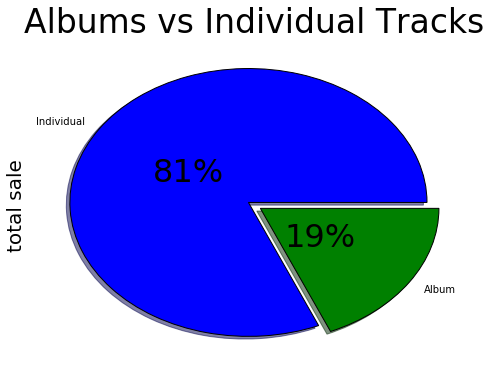

In [47]:
# matplotlib pie-color-chart:

conn = sqlite3.connect("chinook.db")
df_3 = pd.read_sql_query(query, conn)

plt.figure(figsize=(8, 6))

#create pie chart
plt.pie(x = df_3["percent"],
        labels = df_3["Purchase_Type"],
        autopct='%1.0f%%',
        explode=[0.04]*2,
        pctdistance=0.4,
        shadow=True,
        textprops={'fontsize': 32}) 

plt.xticks(fontsize=18)
plt.yticks(fontsize=12)
plt.ylabel("total sale", fontsize=20)
plt.title("Albums vs Individual Tracks", fontsize=33)
plt.show()

From the table we generated above, we can spot that the majority of customers at Chinook purchases individual tracks, around 80%. However, there is still quite a good sum of customers who buy whole albums, 18%. Thus, it would be unwise to limit these customers' freedom at Chinook store, since we will lose out large intake of revenue. I would recommend against purchasing only selected tracks from record companies.

### Do protected vs non-protected media types have an effect on popularity?

In [11]:
%%sql
SELECT 
    CASE
        WHEN mt.name LIKE "Protected%" THEN "Protected"
        ELSE "Non-Protected"
    END AS media_type,
    COUNT(il.invoice_line_id) tracks_sold,
    COUNT(DISTINCT(t.track_id)) no_tracks_available,
    ROUND(COUNT(il.invoice_line_id)*1.0 / COUNT(DISTINCT(t.track_id)),2) avg_sales_per_tracks
FROM track t
LEFT JOIN invoice_line il ON t.track_id = il.track_id
LEFT JOIN invoice i ON i.invoice_id = il.invoice_id
LEFT JOIN media_type mt ON mt.media_type_id = t.media_type_id
GROUP BY media_type
ORDER BY tracks_sold DESC;

Done.


media_type,tracks_sold,no_tracks_available,avg_sales_per_tracks
Non-Protected,4315,3052,1.41
Protected,442,451,0.98


`Non-Protected` tracks are sold 9 times more than `Protected` tracks. So yes, `Non-Protected` media type is a lot more popular in term of sales.